# 简单线性回归

$AQI = k*PM2.5 + b$

In [1]:
import pandas as pd

wh_data = pd.read_csv('../AQI_maincity/武汉.csv', usecols=[0,1,3], index_col='date', encoding='utf-8', engine='python')  # engine='python'解决中文问题
wh_data.head()

,AQI,PM2.5
date,,
2014-01-01,203,153
2014-01-02,231,181
2014-01-03,224,174
2014-01-04,147,112
2014-01-05,195,147


In [2]:
X = wh_data.values[:, 1].reshape(-1,1)  # PM2.5
y = wh_data.values[:, 0]                # AQI

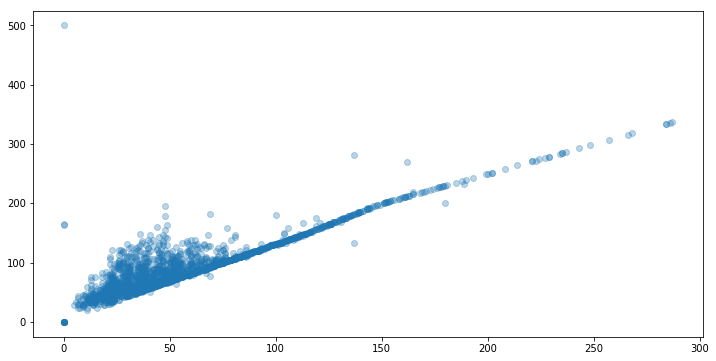

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,6))
plt.scatter(X, y, alpha=0.3)
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

In [5]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

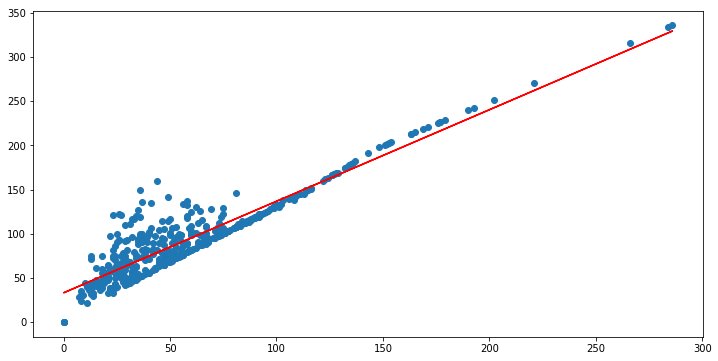

In [6]:
plt.figure(figsize=(12,6))
plt.scatter(X_test, y_test)
plt.plot(X_test, lin_reg.predict(X_test), c='r')
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import sqrt

yhat = lin_reg.predict(X_test)
mse = mean_squared_error(y_test, yhat)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, yhat)
r2 = r2_score(y_test, yhat)
print(mse, rmse, mae, r2)

307.76387550412505 17.54320026403749 13.098962058039692 0.8610501219555409


In [8]:
lin_reg.score(X_test, y_test)

0.8610501219555409

# 多元线性回归

假设函数：$h(x)=X\theta$

参数：$\theta=(\theta_0,...,\theta_n)^{'}$

代价函数：$J(\theta)=\frac{1}{m}\sum^{m}_{i=1}(h(x^{(i)})-y^{(i)})^2$

最优参数：$\hat{\theta}=(X^TX)^{-1}X^Ty$

梯度：$\bigtriangledown J(\theta)=\frac{2}{m}X^T(h(x)-y)$

## 1.导入数据并清洗

In [9]:
import pandas as pd
import numpy as np

wh_data = pd.read_csv('../AQI_maincity/武汉.csv',index_col='date', encoding='utf-8', engine='python')
wh_data.drop(index=wh_data[wh_data['质量等级']=='无'].index, columns=['质量等级'], inplace=True) # 删除异常值和无关变量
wh_data = wh_data.astype(np.float64)
wh_data.index = pd.to_datetime(wh_data.index, format='%Y-%m-%d')
wh_data.head()

,AQI,PM2.5,PM10,SO2,CO,NO2,O3_8h
date,,,,,,,
2014-01-01,203.0,153.0,210.0,70.0,2.0,106.0,55.0
2014-01-02,231.0,181.0,254.0,89.0,2.4,112.0,26.0
2014-01-03,224.0,174.0,226.0,63.0,1.7,84.0,55.0
2014-01-04,147.0,112.0,184.0,73.0,1.6,87.0,40.0
2014-01-05,195.0,147.0,213.0,89.0,2.2,91.0,53.0


## 2.数据探索与可视化

**数据结构**

In [10]:
wh_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1814 entries, 2014-01-01 to 2018-12-31
Data columns (total 7 columns):
AQI      1814 non-null float64
PM2.5    1814 non-null float64
PM10     1814 non-null float64
SO2      1814 non-null float64
CO       1814 non-null float64
NO2      1814 non-null float64
O3_8h    1814 non-null float64
dtypes: float64(7)
memory usage: 113.4 KB


$20140101-20181231$一共1814个样本，6个特征，1个输出值，无缺失值。

**描述性统计信息**

In [11]:
wh_data.describe()

,AQI,PM2.5,PM10,SO2,CO,NO2,O3_8h
count,1814.000000,1814.000000,1814.000000,1814.000000,1814.000000,1814.000000,1814.000000
mean,96.584895,61.116318,94.311466,16.538589,1.090849,48.830761,92.165932
std,47.570103,41.227822,51.390779,13.154913,0.349634,20.225358,49.062929
min,21.000000,0.000000,0.000000,2.000000,0.400000,13.000000,0.000000
25%,64.000000,32.000000,56.000000,7.000000,0.900000,33.000000,53.000000
50%,89.000000,51.000000,86.000000,13.000000,1.000000,45.000000,86.000000
75%,115.000000,79.000000,122.000000,21.000000,1.300000,61.000000,128.000000
max,500.000000,287.000000,406.000000,107.000000,2.700000,119.000000,261.000000


**分布情况**

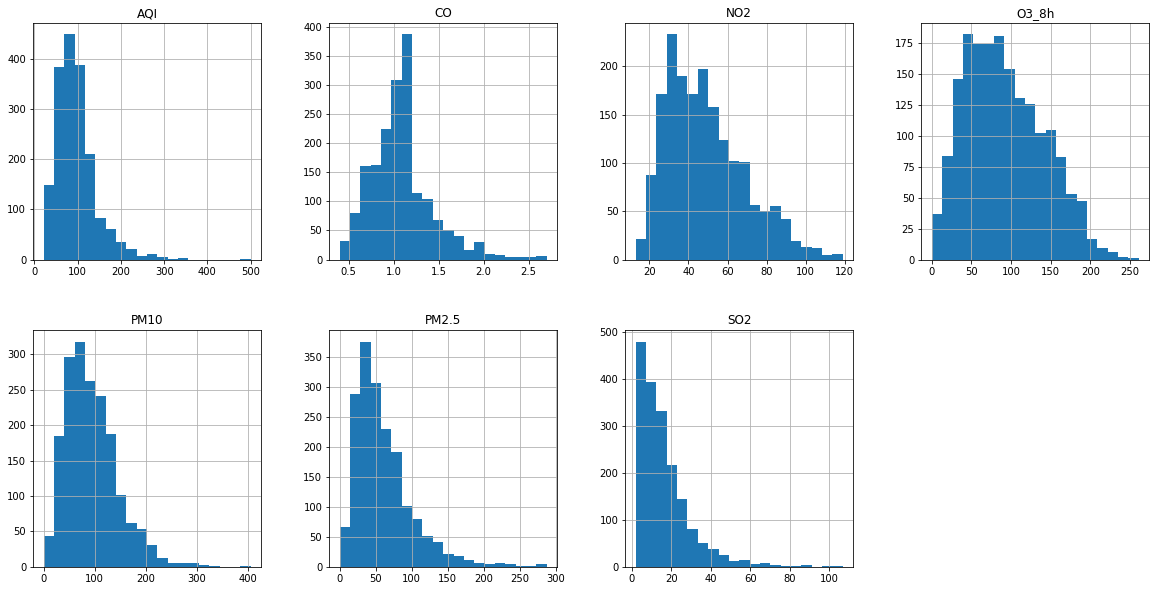

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

wh_data.hist(bins=20, figsize=(20,10), layout=(2,-1))
plt.show()

右边尾部很长。

**相关性检验**

In [13]:
for col in wh_data.columns[1:]:
    print(f'AQI与{col}之间的相关系数：{wh_data["AQI"].corr(wh_data[col])}')

AQI与PM2.5之间的相关系数：0.8951816143963152
AQI与PM10之间的相关系数：0.7894216558137686
AQI与SO2之间的相关系数：0.5346179607747725
AQI与CO之间的相关系数：0.7021153499852832
AQI与NO2之间的相关系数：0.5726237488315274
AQI与O3_8h之间的相关系数：0.04259120167448275


## 3.训练模型

**创建测试集并训练**

In [14]:
from sklearn.model_selection import train_test_split

X, y = wh_data.iloc[:, 1:], wh_data.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [15]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

**评估模型**

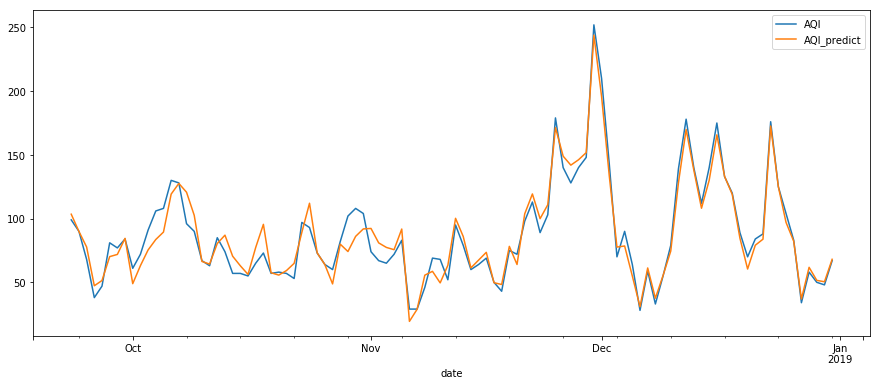

In [16]:
wh_data['AQI_predict'] = lin_reg.predict(X)
wh_data[['AQI', 'AQI_predict']].iloc[-100:].plot(figsize=(15,6))
plt.show()

In [17]:
lin_reg.score(X_test, y_test)

0.73104632406634

In [18]:
print(np.sort(lin_reg.coef_))
print(X.columns[np.argsort(lin_reg.coef_)])

[-1.49645608e-01  3.65634017e-03  4.14736587e-02  2.30029771e-01
  1.03227190e+00  7.01021908e+00]
Index(['SO2', 'NO2', 'PM10', 'O3_8h', 'PM2.5', 'CO'], dtype='object')


## 随机梯度下降法

In [19]:
from sklearn.preprocessing import StandardScaler

standardscaler = StandardScaler()
standardscaler.fit(X_train)
X_train_sca = standardscaler.transform(X_train)
X_test_sca = standardscaler.transform(X_test)

In [20]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000)
sgd_reg.fit(X_train_sca, y_train)
sgd_reg.score(X_test_sca, y_test)

0.731048569515249